<a href="https://colab.research.google.com/github/sravyagadam/ML_Classification/blob/main/AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Balancing Data - Over sampling

In [1]:
!pip install imbalanced-learn >> /dev/null
!pip install smote-variants >> /dev/null
!pip install CatBoost>> /dev/null
!pip install mglearn>>/dev/null


In [2]:
import pandas as pd
import numpy as np
import mglearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer

from numpy import math


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,recall_score,precision_score
import smote_variants as sv
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import cohen_kappa_score
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier



In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# mount drive and give path of dataset
data = pd.read_csv("/content/drive/MyDrive/cardiovascular_Classification_sravya/data_cardiovascular_risk.csv")

In [7]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
181,181,47,3.0,F,NO,0.0,0.0,0,0,0,274.0,127.0,86.0,21.93,90.0,83.0,0
1465,1465,63,2.0,F,YES,9.0,0.0,0,1,0,219.0,162.0,91.0,33.66,70.0,NaN,0
1731,1731,49,2.0,F,YES,20.0,0.0,0,0,0,283.0,127.0,86.0,23.68,95.0,78.0,0
822,822,62,4.0,M,YES,40.0,0.0,0,1,0,203.0,148.0,96.0,30.84,70.0,95.0,1
1160,1160,45,3.0,F,NO,0.0,0.0,0,0,0,254.0,104.0,73.0,19.46,60.0,77.0,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [9]:
data[["diabetes","glucose"]]

,diabetes,glucose
0,0,80.0
1,0,75.0
2,0,94.0
3,0,94.0
4,0,77.0
...,...,...
3385,0,103.0
3386,0,84.0
3387,0,72.0
3388,0,85.0


In [10]:
# duplicate
len(data[data.duplicated()])

0

In [11]:
data.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

##Dealing with null values

In [12]:
#Check values of diabetes where glucose is null
data[data['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

In [13]:
## Null handling for column glucose
data.loc[(data['glucose'].isna()) & (data['diabetes']==0) ,['glucose'] ]=data[data['diabetes']==0]['glucose'].median()
data.loc[(data['glucose'].isna()) & (data['diabetes']==1) ,['glucose'] ]=data[data['diabetes']==1]['glucose'].median()

In [14]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

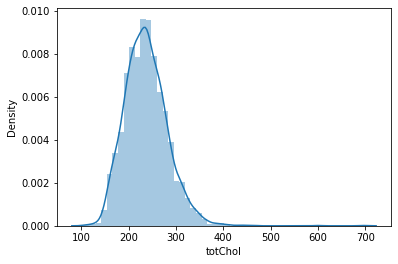

In [15]:
sns.distplot(data['totChol']);

In [16]:
# Ipute with median
data['totChol']=data['totChol'].fillna(data['totChol'].median())
# Impute with median
data['BMI']=data['BMI'].fillna(data['BMI'].median())

In [17]:
# Impute with random number between 5 and 30
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))
# Impute with mean, only one null value
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))
# Encoding the categorical columns
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

In [18]:
data.isna().sum()

id                  0
age                 0
education          87
sex                 0
is_smoking          0
cigsPerDay          0
BPMeds              0
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [24]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [25]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [26]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [27]:
data_trans.isna().sum().sum()

0

In [28]:
data=data_trans.copy()

EDA Part 

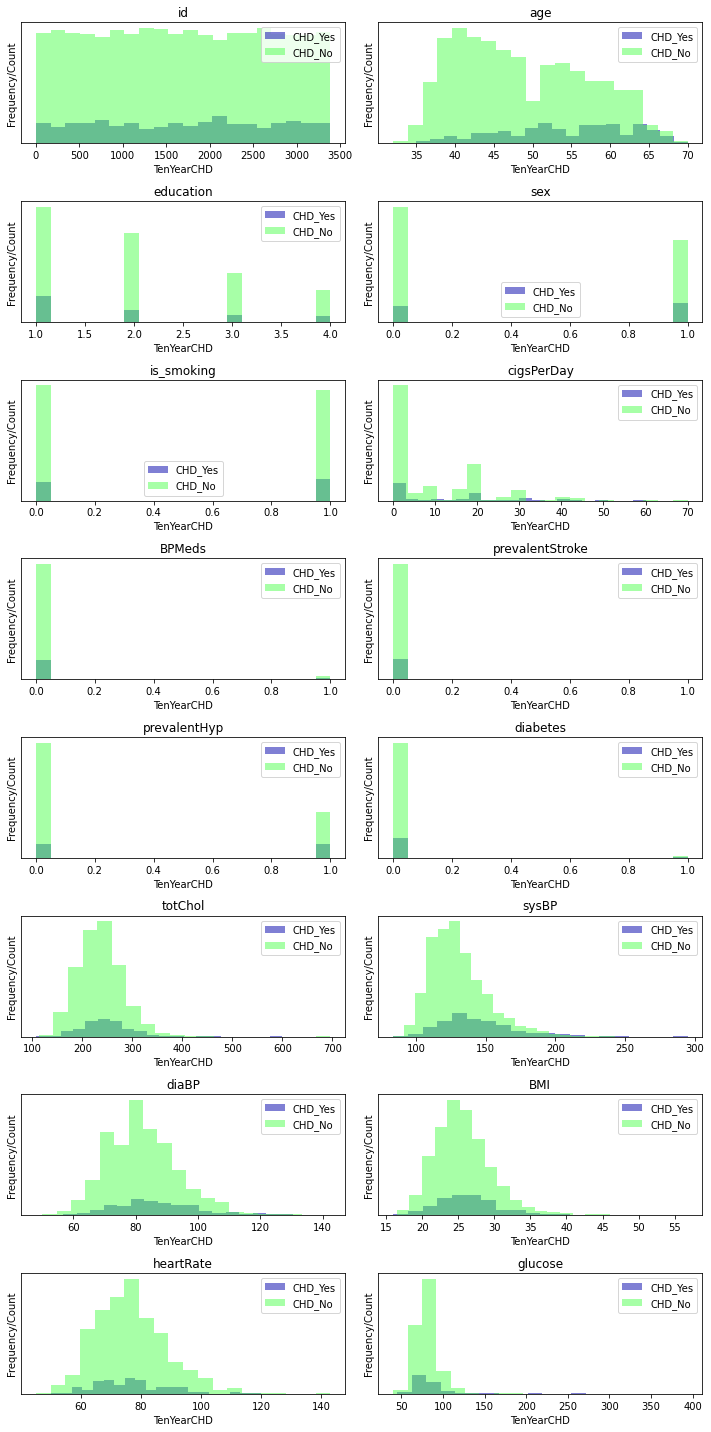

In [19]:
Risk_Yes =data.loc[data['TenYearCHD']==1]
Risk_No =data.loc[data['TenYearCHD']==0]
fig, axes = plt.subplots(8,2, figsize=(10,20))
ax = axes.ravel()
for i in range(16):
  ax[i].hist(Risk_Yes.iloc[:,i], bins=20, color=mglearn.cm3(0), alpha=.5)
  ax[i].hist(Risk_No.iloc[:,i], bins=20, color=mglearn.cm3(2), alpha=.5)
  ax[i].set_title(list(Risk_Yes)[i])
  ax[i].set_yticks(())
  ax[i].set_xlabel("TenYearCHD")
  ax[i].set_ylabel("Frequency/Count")
  ax[i].legend(["CHD_Yes", "CHD_No"], loc="best")
fig.tight_layout()

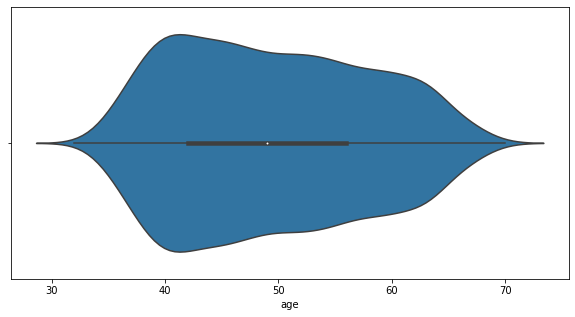

In [20]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data['age'])
plt.show()

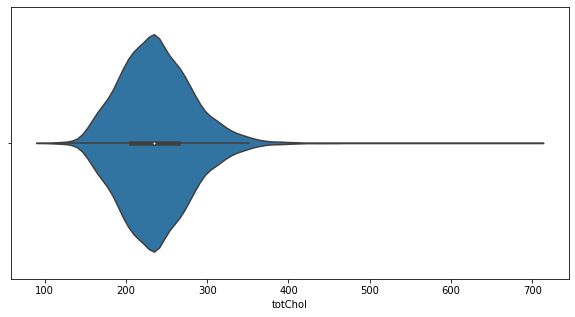

In [21]:
plt.figure(figsize = (10,5))
ax= sns.violinplot(data['totChol'])
plt.show()

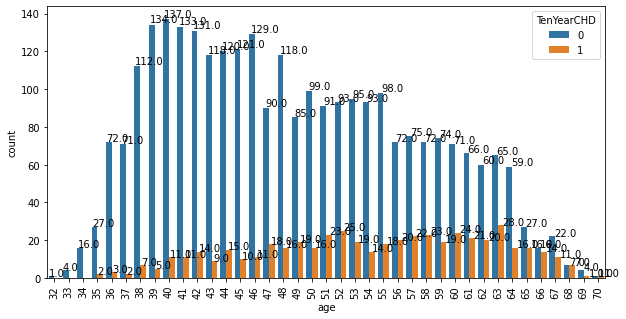

In [22]:
plt.figure(figsize = (10,5))
ax= sns.countplot(x = "age", hue = "TenYearCHD", data = data)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.xticks(rotation = 90)
plt.show()

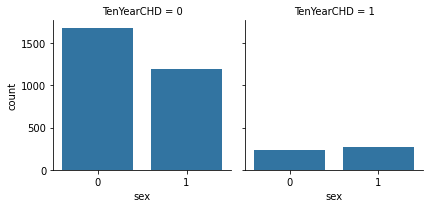

In [23]:


fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

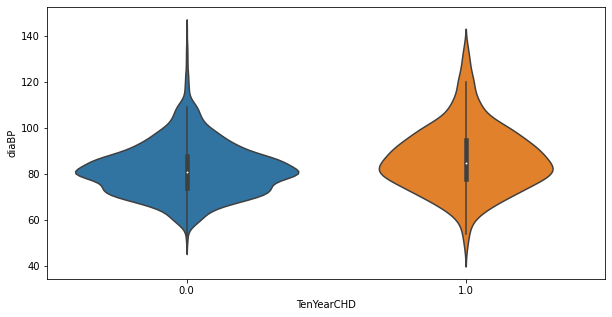

In [49]:
plt.figure(figsize = (10,5))
sns.violinplot(y = 'diaBP', x = 'TenYearCHD', data = data)
plt.show()

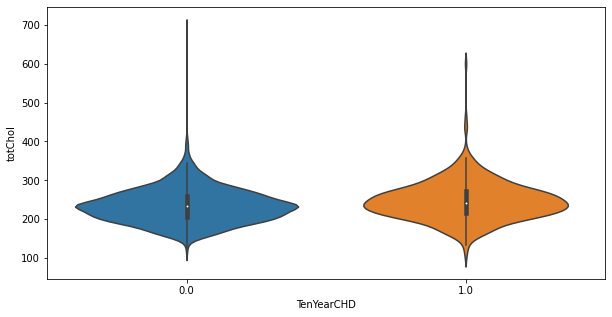

In [50]:
plt.figure(figsize = (10,5))
sns.violinplot(y = 'totChol', x = 'TenYearCHD', data = data)
plt.show()


##Dropping irrelavant variables and duplicates if any.

In [29]:
data.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [30]:
data.drop("id", axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [31]:
data.shape

(3390, 16)

here shape confirms that there are no duplicates and total columns reduced to 16

In [32]:
data.describe()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.00000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000
mean,49.542183,1.971386,0.432743,0.497640,9.185841,0.029499,0.006490,0.315339,0.025664,237.039823,132.60118,82.883038,25.793251,75.977279,81.783776,0.150737
std,8.592878,1.007579,0.495529,0.500068,11.927697,0.169224,0.080309,0.464719,0.158153,44.994205,22.29203,12.023581,4.107026,11.970102,23.249836,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.030000,68.000000,72.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,1.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,27.997500,83.000000,85.000000,0.000000
max,70.000000,4.000000,1.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [33]:
unique, counts = np.unique(data['TenYearCHD'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 2.879e+03]
 [1.000e+00 5.110e+02]]


It is evident that the dataset is imbalanced as it comprises of very few CHD-Yes(444) cases in comparision to CHD-No(2483) cases. Therfore, we need to balance them before we provide it to our model training.

In [34]:

X=data.drop(['TenYearCHD'],axis=1).values
y=data['TenYearCHD'].values

In [35]:
# handling data imbalance
oversampler= sv.distance_SMOTE()
X_msmote, y_msmote= oversampler.sample(X, y)

2021-12-29 13:23:19,356:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [36]:
#Create new Dataframe with balanced data
data_new=pd.DataFrame(X_msmote,columns=data.columns[:-1])
data_new['TenYearCHD']=pd.DataFrame(y_msmote)
data_new['TenYearCHD'].value_counts()

0.0    2879
1.0    2879
Name: TenYearCHD, dtype: int64

In [37]:
# Split traget and independent features
X=data_new.drop(['TenYearCHD'],axis=1)
y=data_new['TenYearCHD']

In [38]:
#Difference of BP to create a new feature
X['pulse']=X['sysBP']-X['diaBP']
X.drop(['sysBP','diaBP'],axis=1,inplace=True)

In [39]:
# Split data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)

In [40]:
# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [41]:
corr = data.corr()
corr[-3:]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
heartRate,-0.002595,-0.046119,-0.118680,0.062176,0.066306,0.018103,-0.019184,0.150766,0.039742,0.086945,0.178178,0.174893,0.069511,1.000000,0.079693,0.020224
glucose,0.111474,-0.036033,-0.003555,-0.058201,-0.062650,0.060645,0.023350,0.082752,0.624309,0.059785,0.141086,0.070609,0.087148,0.079693,1.000000,0.134363
TenYearCHD,0.224927,-0.053832,0.084647,0.034143,0.063327,0.087349,0.068627,0.166544,0.103681,0.093605,0.212703,0.135979,0.066134,0.020224,0.134363,1.000000


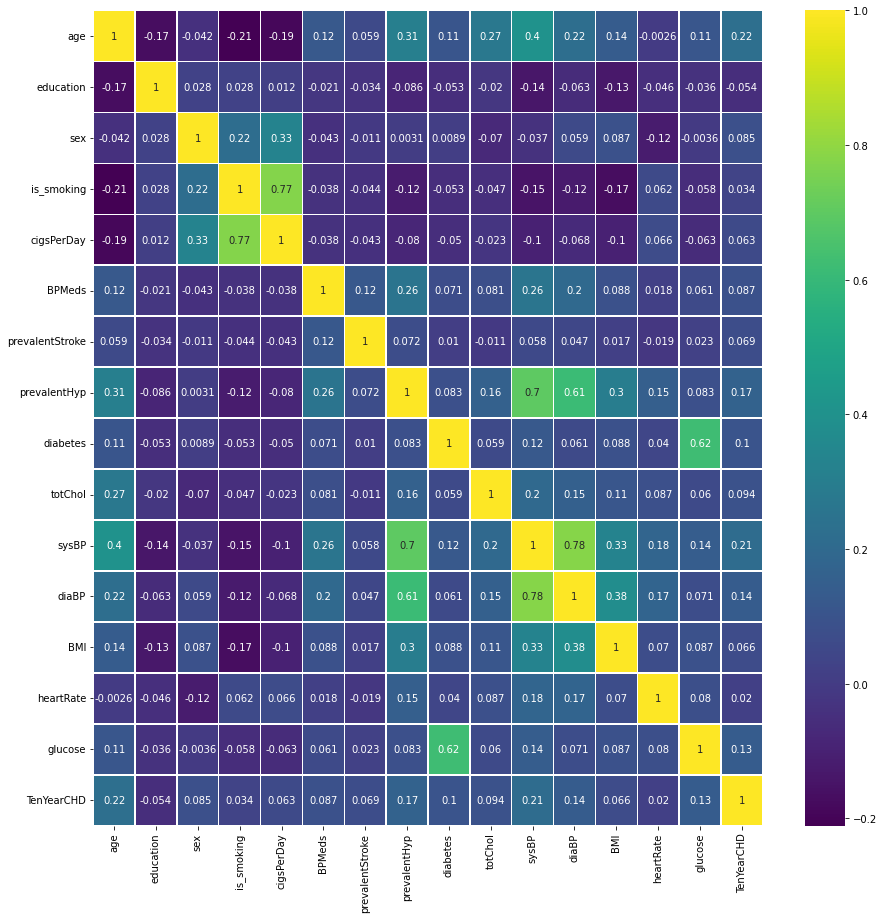

In [42]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True, cmap='viridis', linewidths=.5)

In [43]:
unique, counts = np.unique(data['TenYearCHD'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 2.879e+03]
 [1.000e+00 5.110e+02]]


Here is a data ready to be trained and tested, using any machine learning classification algorithm. 

## Decision Tree Classification

Training the Decision Tree Classification model on the Training set

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Making the Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(439, 428, 63, 64)

Calculating accuracy score

In [ ]:
accuracy_score_DecisionTree = accuracy_score(y_test, y_pred)
print(accuracy_score_DecisionTree)

0.8722334004024145


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.75426621 0.76450512 0.80204778 0.75767918 0.80204778 0.76791809
 0.72013652 0.76027397 0.7739726  0.75342466]
The Cross Validation accuracy is: 76.56%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       491
           1       0.87      0.87      0.87       503

    accuracy                           0.87       994
   macro avg       0.87      0.87      0.87       994
weighted avg       0.87      0.87      0.87       994



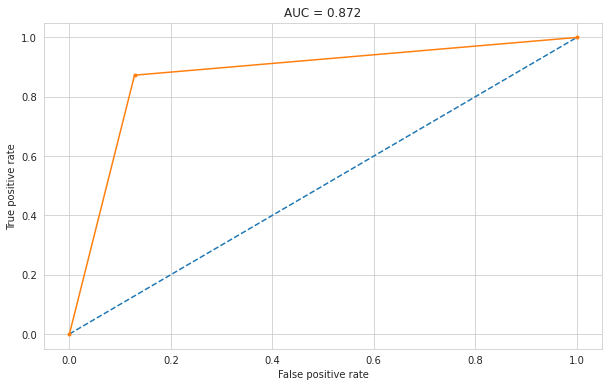

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

Hyper parameter tuning

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [ ]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 439 ms, sys: 59.8 ms, total: 498 ms
Wall time: 4.59 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011981,0.003491,0.000959,0.000057,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
1,0.015548,0.004004,0.000941,0.000037,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
2,0.012630,0.005926,0.000899,0.000050,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
3,0.017043,0.004781,0.001835,0.001600,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37
4,0.020378,0.006701,0.000965,0.000033,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.851964,0.835851,0.850957,0.850957,0.847432,0.006699,37


In [ ]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
42,0.030880,0.009524,0.000971,0.000027,entropy,10,20,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.894260,0.861027,0.892246,0.877140,0.881168,0.013379,1
47,0.030087,0.003896,0.001024,0.000059,entropy,20,20,"{'criterion': 'entropy', 'max_depth': 20, 'min...",0.894260,0.861027,0.892246,0.877140,0.881168,0.013379,1
17,0.028241,0.008008,0.000981,0.000078,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.890232,0.875126,0.880161,0.877140,0.880665,0.005807,3
22,0.032284,0.005096,0.004094,0.005251,gini,20,20,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.890232,0.875126,0.880161,0.877140,0.880665,0.005807,3
41,0.055073,0.006332,0.000988,0.000051,entropy,10,10,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.889225,0.864048,0.884189,0.884189,0.880413,0.009669,5


In [ ]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)

In [ ]:
dt_best = grid_search.best_estimator_

In [ ]:
classifier_tuning = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)
classifier_tuning.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=20,
                       random_state=42)

In [ ]:
y_pred = classifier_tuning.predict(X_test_scaled)
tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, y_pred).ravel()
tp_t,fp_t, fn_t, tp_t

(417, 30, 86, 417)

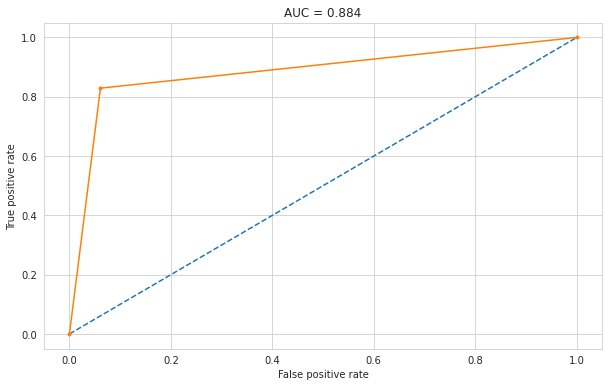

In [ ]:
# ROC curve and AUC 
probs = classifier_tuning.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##K-Nearest Neighbors (K-NN)

Training the K-NN model on the Training set

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(475, 373, 118, 28)

Calculating accuracy score

In [ ]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_KNNClassifier)

0.8531187122736419


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.83959044 0.8225256  0.83959044 0.81911263 0.82935154 0.84300341
 0.84641638 0.8390411  0.83561644 0.82191781]
The Cross Validation accuracy is: 83.36%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       491
           1       0.80      0.94      0.87       503

    accuracy                           0.85       994
   macro avg       0.87      0.85      0.85       994
weighted avg       0.86      0.85      0.85       994



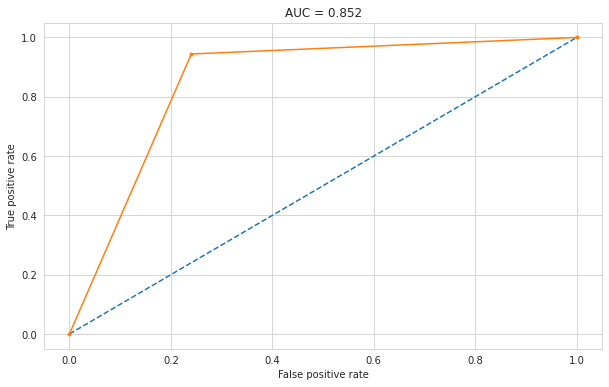

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Kernel SVM

Training the Kernel SVM model on the Training set

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(random_state=0)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(406, 440, 51, 97)

Calculating accuracy score

In [ ]:
accuracy_score_KernalSVM = accuracy_score(y_test, y_pred)
print(accuracy_score_KernalSVM)

0.8511066398390342


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84641638 0.84982935 0.84982935 0.84641638 0.84641638 0.84641638
 0.84982935 0.84931507 0.84589041 0.84931507]
The Cross Validation accuracy is: 84.8%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       491
           1       0.89      0.81      0.85       503

    accuracy                           0.85       994
   macro avg       0.85      0.85      0.85       994
weighted avg       0.85      0.85      0.85       994



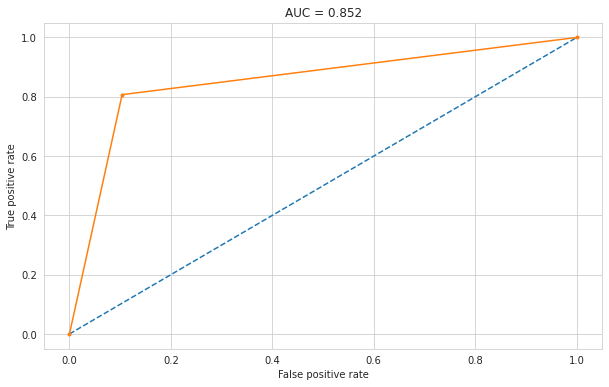

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Logistic Regression

In [ ]:
# the hashtag is used to represent "experimental coding as per almabetter classes"

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_validate

In [ ]:
# logistic = LogisticRegression()

In [ ]:
# scoring = ['accuracy']
# scores = cross_validate(logistic,X_train, y_train, scoring = scoring , cv = 10, return_train_score=True,return_estimator=True,verbose = 10)

In [ ]:
# scores['train_accuracy']

In [ ]:
# scores['test_accuracy']

In [ ]:
# scores['estimator']

Training the Logistic Regression model on the Training set

In [ ]:
# search for optimun parameters using gridsearch
params = {'penalty':['l1','l2'],
         'C':[0.01,0.1,1,10,100],
         'class_weight':['balanced',None]}
classifier = GridSearchCV(LogisticRegression(),param_grid=params,cv=10)

In [ ]:
#train the classifier
classifier.fit(X_train_scaled,y_train)

classifier.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [ ]:
#make predictions
y_pred = classifier.predict(X_test_scaled)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(X_train_scaled, y_train)

In [ ]:
log_accuracy = accuracy_score(y_test,y_pred)
print(f"Using logistic regression we get an accuracy of {round(log_accuracy*100,2)}%")

Using logistic regression we get an accuracy of 70.93%


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Streaming output truncated to the last 5000 lines.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:81

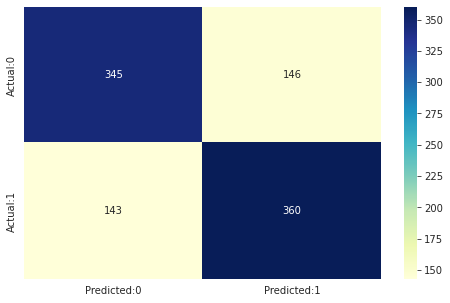

In [ ]:
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Making the Confusion Matrix

In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# y_pred = classifier.predict(X_test_scaled)
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# tp, tn, fp, fn

(357, 350, 141, 146)

Calculating accuracy score

In [ ]:
accuracy_score_LogisticRegression = accuracy_score(y_test, y_pred)
print(accuracy_score_LogisticRegression)

0.7112676056338029


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       491
           1       0.72      0.71      0.71       503

    accuracy                           0.71       994
   macro avg       0.71      0.71      0.71       994
weighted avg       0.71      0.71      0.71       994



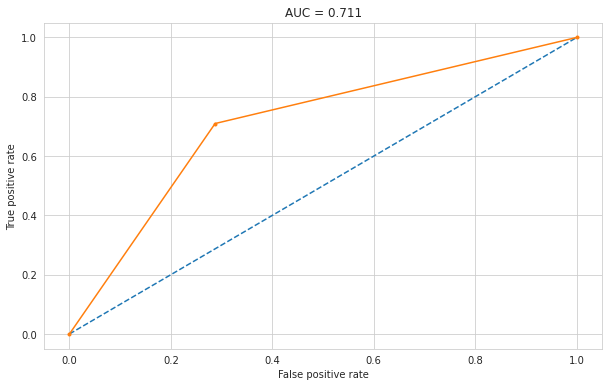

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Naive Bayes

Training the Naive Bayes model on the Training set

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train_scaled, y_train)

GaussianNB()

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(230, 426, 65, 273)

Calculating accuracy score

In [ ]:
accuracy_score_NaiveBayes = accuracy_score(y_test, y_pred)
print(accuracy_score_NaiveBayes)

0.6599597585513078


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.8225256  0.83276451 0.83959044 0.79522184 0.83959044 0.8225256
 0.83617747 0.81849315 0.82876712 0.81164384]
The Cross Validation accuracy is: 82.47%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.87      0.72       491
           1       0.78      0.46      0.58       503

    accuracy                           0.66       994
   macro avg       0.69      0.66      0.65       994
weighted avg       0.70      0.66      0.65       994



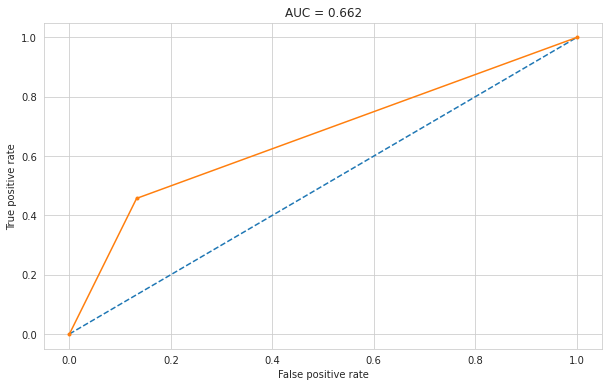

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Random Forest Classification

Training the Random Forest Classification model on the Training set

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(420, 479, 12, 83)

Calculating accuracy score

In [ ]:
accuracy_score_RandomForest = accuracy_score(y_test, y_pred)
print(accuracy_score_RandomForest)

0.9044265593561368


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84641638 0.82935154 0.85324232 0.83276451 0.84641638 0.85665529
 0.82935154 0.8390411  0.83219178 0.84589041]
The Cross Validation accuracy is: 84.11%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       491
           1       0.97      0.83      0.90       503

    accuracy                           0.90       994
   macro avg       0.91      0.91      0.90       994
weighted avg       0.91      0.90      0.90       994



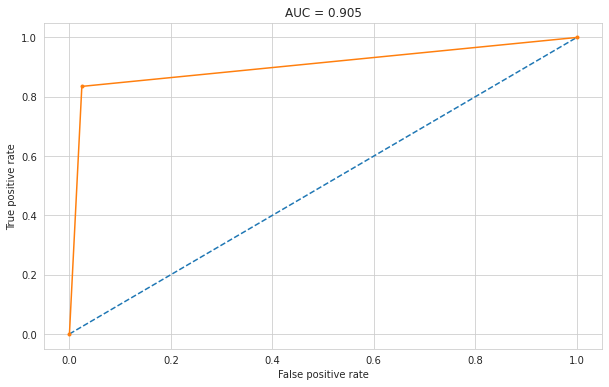

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Support Vector Machine (SVM)

Training the SVM model on the Training set

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=0)

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(370, 333, 158, 133)

Calculating accuracy score

In [ ]:
accuracy_score_SVM = accuracy_score(y_test, y_pred)
print(accuracy_score_SVM)

0.7072434607645876


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84982935 0.84982935 0.84982935 0.84641638 0.84641638 0.84641638
 0.84641638 0.84931507 0.84931507 0.84931507]
The Cross Validation accuracy is: 84.83%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70       491
           1       0.70      0.74      0.72       503

    accuracy                           0.71       994
   macro avg       0.71      0.71      0.71       994
weighted avg       0.71      0.71      0.71       994



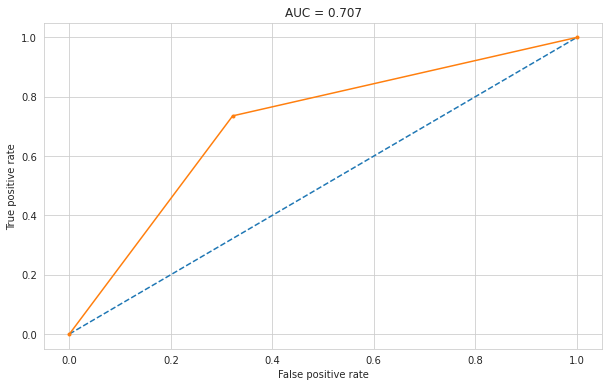

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##XGB Classifier

Training XGBClassifier model on the Training set

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train_scaled, y_train)

XGBClassifier()

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(422, 485, 6, 81)

Calculating accuracy score

In [ ]:
accuracy_score_XGBClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_XGBClassifier)

0.9124748490945674


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Cross-validated scores [0.84641638 0.85665529 0.85665529 0.84982935 0.84982935 0.84641638
 0.83617747 0.84246575 0.84589041 0.85273973]
The Cross Validation accuracy is: 84.83%


Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       491
           1       0.99      0.84      0.91       503

    accuracy                           0.91       994
   macro avg       0.92      0.91      0.91       994
weighted avg       0.92      0.91      0.91       994



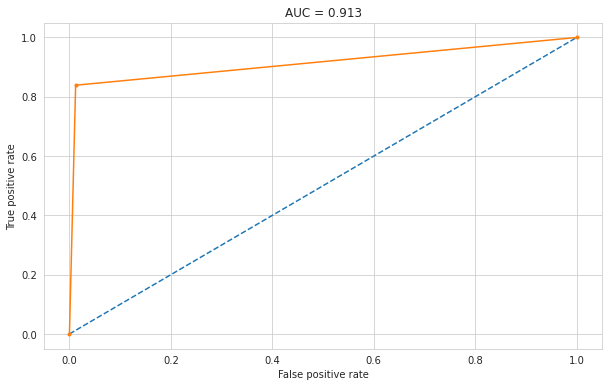

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test_scaled)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##CatBoost Classifier

Training the CatBoostClassifier model on the Training set

In [ ]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)

Learning rate set to 0.018566
0:	learn: 0.6687854	total: 6.15ms	remaining: 6.15s
1:	learn: 0.6455314	total: 11ms	remaining: 5.48s
2:	learn: 0.6245363	total: 16.2ms	remaining: 5.4s
3:	learn: 0.6025934	total: 21.1ms	remaining: 5.26s
4:	learn: 0.5841153	total: 26.1ms	remaining: 5.18s
5:	learn: 0.5646381	total: 30.9ms	remaining: 5.11s
6:	learn: 0.5479762	total: 38.2ms	remaining: 5.41s
7:	learn: 0.5305588	total: 49.5ms	remaining: 6.13s
8:	learn: 0.5141327	total: 57.1ms	remaining: 6.29s
9:	learn: 0.4996802	total: 62ms	remaining: 6.14s
10:	learn: 0.4868325	total: 67.4ms	remaining: 6.06s
11:	learn: 0.4747921	total: 72.4ms	remaining: 5.96s
12:	learn: 0.4631723	total: 77.4ms	remaining: 5.88s
13:	learn: 0.4514826	total: 82.7ms	remaining: 5.82s
14:	learn: 0.4410314	total: 87.6ms	remaining: 5.75s
15:	learn: 0.4317965	total: 92.5ms	remaining: 5.69s
16:	learn: 0.4235223	total: 97.3ms	remaining: 5.63s
17:	learn: 0.4147225	total: 102ms	remaining: 5.58s
18:	learn: 0.4072776	total: 107ms	remaining: 5.54s

Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn 

(422, 486, 5, 81)

Calculating accuracy score

In [ ]:
accuracy_score_CatBoost = accuracy_score(y_test, y_pred)
print(accuracy_score_CatBoost)

0.9134808853118712


In [ ]:
#Cross Validation
cv_results = cross_val_score(classifier, X, y, cv=10) 

print (f"Cross-validated scores {cv_results}")
print(f"The Cross Validation accuracy is: {round(cv_results.mean() * 100,2)}%")

Streaming output truncated to the last 5000 lines.
7:	learn: 0.6144755	total: 29.6ms	remaining: 3.67s
8:	learn: 0.6067516	total: 31.2ms	remaining: 3.44s
9:	learn: 0.5994559	total: 33.3ms	remaining: 3.29s
10:	learn: 0.5918361	total: 35.4ms	remaining: 3.18s
11:	learn: 0.5841728	total: 37.5ms	remaining: 3.09s
12:	learn: 0.5771342	total: 39.5ms	remaining: 3s
13:	learn: 0.5705636	total: 41.7ms	remaining: 2.93s
14:	learn: 0.5649686	total: 43.8ms	remaining: 2.88s
15:	learn: 0.5592282	total: 46ms	remaining: 2.83s
16:	learn: 0.5537110	total: 48.1ms	remaining: 2.78s
17:	learn: 0.5479466	total: 50.3ms	remaining: 2.74s
18:	learn: 0.5424247	total: 52.6ms	remaining: 2.72s
19:	learn: 0.5368921	total: 54.7ms	remaining: 2.68s
20:	learn: 0.5317086	total: 57.1ms	remaining: 2.66s
21:	learn: 0.5267350	total: 59.4ms	remaining: 2.64s
22:	learn: 0.5215863	total: 61.7ms	remaining: 2.62s
23:	learn: 0.5164938	total: 63.9ms	remaining: 2.6s
24:	learn: 0.5120620	total: 66.2ms	remaining: 2.58s
25:	learn: 0.5076312	t

Classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       491
           1       0.99      0.84      0.91       503

    accuracy                           0.91       994
   macro avg       0.92      0.91      0.91       994
weighted avg       0.92      0.91      0.91       994



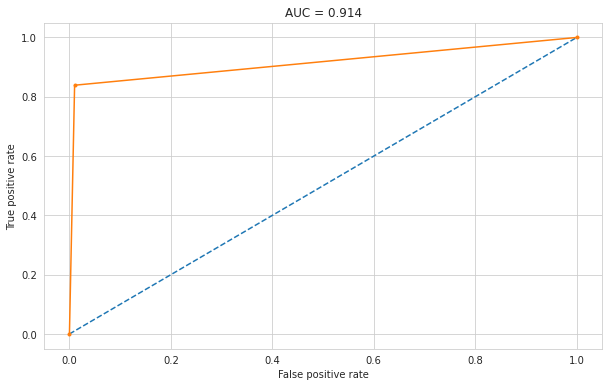

In [ ]:
# ROC curve and AUC 
probs = classifier.predict(X_test)
# keep probabilities for the positive outcome only
# probs = probs[:, 1]
# calculate AUC
log_auc = roc_auc_score(y_test, probs)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title(f"AUC = {round(log_auc,3)}")
plt.show()

##Accuracy Scores of each classification model are as follows 

In [ ]:
print(f'''Accuracy Scores:

Decision Tree Classification: {accuracy_score_DecisionTree}
K Nearest Neigbours         : {accuracy_score_KNNClassifier}
Kernal SVM                  : {accuracy_score_KernalSVM}
Logistic Regression         : {accuracy_score_LogisticRegression}
Naive Bayes                 : {accuracy_score_NaiveBayes}
Random Forest Classification: {accuracy_score_RandomForest}
Support Vector Machine      : {accuracy_score_SVM}
XGB Classifier              : {accuracy_score_XGBClassifier}
CatBoost Classifier         : {accuracy_score_CatBoost}
''')

Accuracy Scores:

Decision Tree Classification: 0.8601609657947686
K Nearest Neigbours         : 0.8531187122736419
Kernal SVM                  : 0.8450704225352113
Logistic Regression         : 0.7173038229376257
Naive Bayes                 : 0.6670020120724346
Random Forest Classification: 0.9114688128772636
Support Vector Machine      : 0.7132796780684104
XGB Classifier              : 0.9144869215291751
CatBoost Classifier         : 0.9114688128772636



In [ ]:
'''
Accuracy Scores: Before Balancing data vs Balancing Data-SMOTE vs Balancing Data-MSMOTE

Decision Tree Classification: 0.7679180887372014
K Nearest Neigbours         : 0.8191126279863481
Kernal SVM                  : 0.8378839590443686
Logistic Regression         : 0.8395904436860068
Naive Bayes                 : 0.8088737201365188
Random Forest Classification: 0.8191126279863481
Support Vector Machine      : 0.8395904436860068
XGB Classifier              : 0.8327645051194539
CatBoost Classifier         : 0.8327645051194539



Decision Tree Classification: 0.831096196868009
K Nearest Neigbours         : 0.7975391498881432
Kernal SVM                  : 0.7684563758389261
Logistic Regression         : 0.6868008948545862
Naive Bayes                 : 0.6006711409395973
Random Forest Classification: 0.8713646532438478
Support Vector Machine      : 0.6767337807606264
XGB Classifier              : 0.8501118568232662
CatBoost Classifier         : 0.8747203579418344



Decision Tree Classification: 0.8601609657947686
K Nearest Neigbours         : 0.8531187122736419
Kernal SVM                  : 0.8450704225352113
Logistic Regression         : 0.7173038229376257
Naive Bayes                 : 0.6670020120724346
Random Forest Classification: 0.9114688128772636
Support Vector Machine      : 0.7132796780684104
XGB Classifier              : 0.9144869215291751
CatBoost Classifier         : 0.9114688128772636

'''

'\nAccuracy Scores: Before Balancing data vs Balancing Data-SMOTE vs Balancing Data-MSMOTE\n\nDecision Tree Classification: 0.7679180887372014\nK Nearest Neigbours         : 0.8191126279863481\nKernal SVM                  : 0.8378839590443686\nLogistic Regression         : 0.8395904436860068\nNaive Bayes                 : 0.8088737201365188\nRandom Forest Classification: 0.8191126279863481\nSupport Vector Machine      : 0.8395904436860068\nXGB Classifier              : 0.8327645051194539\nCatBoost Classifier         : 0.8327645051194539\n\n\n\nDecision Tree Classification: 0.831096196868009\nK Nearest Neigbours         : 0.7975391498881432\nKernal SVM                  : 0.7684563758389261\nLogistic Regression         : 0.6868008948545862\nNaive Bayes                 : 0.6006711409395973\nRandom Forest Classification: 0.8713646532438478\nSupport Vector Machine      : 0.6767337807606264\nXGB Classifier              : 0.8501118568232662\nCatBoost Classifier         : 0.8747203579418344\n\